### Author: Md Fahim Hasan
### Work Email: mdfahim.hasan@bayer.com

## Read me

This script processes weather datasets (TWC and ERA5) that have been downloaded from CSW. The query codes of weather data  are in `query_codes/weather_data_query.ipnyb'`. 

The following steps have been followed for processing the weather datasets. 

**1. TWC (to 4km)** 
- __1.1. Converting grid points to polygon:__ TWC grid info only has lat, lon coordinates, not grid polygon. To rasterize TWC data we need grid polygons. The grid polygon geometry has been created using `convert_point_geom_to_poly_geom_from_centroid()` function.
- __1.2. Rasterization:__ The datasets were rasterized to TWC original grid size (4km/0.036 deg) using `polygon scale` (see Note**) TWC grid information (created at 1st step). This can be done with the function `process_twc_daily_data()`. This function also creates and saves two lat & lon rasters that represents the centroid of each pixel.
- __1.3. Masking with shapefile:__ The TWC data was downloaded and rasterized for a buffered region around the `selected_cities` of California, but we are building model for a area of `selected_cities_California/cities_California`. Therefore, each daily data for California was masked with the `cities_California_dissolved.shp` shapefile. The selected AOI can be seen in the following grid plots.
- __1.4. Compiling datasets to dataframe__: The daily dataset was compiled into a dataframe where each row corresponds to a pixel of the daily data and each column stands for an attribure. The dataframe was incorporated with lat/lon information as well. This can be done with the `compile_twc_daily_data_to_dataframe()` function. 
----


**2. TWC (to 8km)**
- TWC high resolution precipitation data comes in 8km native resolution, therefore, was processed to 8km pixel size using similar steps that of `TWC (to 4km)`.
----

**3. ERA5 (to 4km)**
- __3.1. Rasterization and Resampling:__ The datasets were rasterized to ERA5 original grid size (28km/0.25 deg) using ERA5 `point scale` grid information. The rasterized data is of 28km but our target resolution is 4km. So, after rasterization the data has been resampled to 4km. Both the rasterization and resampling can be done with the function`process_era5_daily_data()`. 
- __3.2. Masking with shapefile:__ The ERA5 data was downloaded and rasterized for a buffered region around the `selected_cities` of California, but we are building model for a area of `selected_cities_California/cities_California`. Therefore, each daily data for California was masked with the `cities_California_dissolved.shp` shapefile. The selected AOI can be seen in the following grid plots.
- __3.3. Copying latitude longitude data from TWC to ERA5:__ The ERA5 original dataset has lat & lon info for 28km grid, but we need this info for 4km grids. Therefore, lat lon datasets from TWC has been copied to ERA5 data folder. We use the same lat lon info in TWC and ERA5 because we need to compile these datasets afterwards.
- __3.4. Copying Elevation + Slope + Aspect Data:__ The machine learning models will use Elevation+Slope+Aspect data as input variables. So, 4km resolution Elevation + Slope + Aspect dataset were copied to the folder of 4km resolution resampled ERA5 datasets. Later on, the Elevation + Slope + Aspect datasets will be compiled inot a dataframe with the ERA5 datasets. __Note-__ The Elevation + Slope + Aspect datasets have been rasterized and processed to 4km/8km in the `processing_DEM_slope_data.ipynb` script.
- __3.5 Compiling datasets to dataframe__: The daily datasets were compiled to a dataframe where each row corresponds to a pixel of the daily data and each column stands for an attribure. The dataframe was incorporated with lat/lon information as well. This can be done with the `compile_era5_daily_data_to_multiple_dataframe()` function. This function can process data in chunks of variables and save it in chunks of dataframe as well. Similar approach can be applied for processing TWC data to dataframe (not currently implemented).
----

**4. ERA5 (to 8km)**
- To build ML model for precipitation (using TWC 8km precipitation data as observation data), ERA5 datasets need to be processed to 8km resolution so that they can be used as predictors/predictands.So, ERA5 datasets were processed to 8km pixel sizes using similar steps that of `ERA5 (to 4km)`.
-----
 
**5/6. Combining TWC and ERA5 Dataframes**

The TWC and ERA5 datasets are joined together (merged) on Date + Latitude + Longitude. The merging operation can be performed with the `combine_twc_era5_datasets()` function. The merged dataframe will work as the predictor dataset of different ML models (for precipitation/temperature... ), where ERA5 variables will be used as predictors/predictands and TWC variables will be used as training/observation data. These models will be used to interpolated/increase resolution of ERA5 from 28km to 4km. 

-----------------

### Note**

- __Region of Interest (ROI)__
We chose some `selected cities in Califoania` as the Region of Interest (ROI). The ROI consists of some parts of the Central Valley, California that has significant agriculture. The ROI selection was based on consideration that it should overlap some `Testing Fields` in that region.
----
- In TWC data rasterization process, the TWC dataset values were transferred from point scale TWC grid info to polygon scale (used a function to convert point to 4km polygons) first, and then rasterization was done.
---

- __TWC/ERA5 grid center not matching with TWC/ERA5 raster pixels' centroid:__  There might be some `slight shift` in rasterized TWC/ERA5 datasets from the TWC/ERA5 polygon grids's center (center-to-center doesn't match). This is because during the rasterization process, we used `cities_california_buffer_28km_refraster / cities_california_buffer_4km_refraster`  as reference rasters. Thse reference rasters were not created using the TWC/ERA5 polygon grids file, rather `cities_California_buffer.shp` (look into `shapefile_grids` directory for the file). During the rasterization process, the `rasterize_shapefile()` function is only concerned about matching the height-width of the rasterized data with the reference rasters. In future, for center-to-center match between rasterized data and grid polygon center, the rasterization process should take into account both reference raster height and width and grid cell center. Anyway, this shouldn't affect much in the modeling effort but it is recommneded to use a reference raster created from TWC polygon grids in future.

__Note-__ This center-to-center `not matching` issue is connected to other issues as well, e.g., the TWC data grid size isn't perfectly 4km. Look into the `Discussion.inynb` for further discussion.

---
- During rasterization of ERA5 data I used ERA5 point scale grid info (shapefile) directly without converting the point scale grid info to polygon (like I did TWC).
---
- For rasterizing to 28km (ERA5 data), use similar reference raster all over. For rasterization/resampling to 4km (both TWC and ERA5 data), use similar reference raster all over.
---
- __Processing ERA5 datasets in chunks-__ ERA5 datasets have more than 20 variables with long temporal records. If processed all at once, this will cause regular instances to freeze due to memory issue. So, the ERA5 datasets were processed in chunks. In this approach, 'n' number of datasets will be processed together and saved as a parquet  files. This can be done using the `compile_era5_daily_data_to_multiple_dataframe()` function. This function processes data in chunks of variables and save it in chunks of dataframe. Multiple parquet files is generated and they need to be joined together to create a single ERA5 dataframe with all the ERA5 variables.

    Currently, this processing in chunks approach has been applied only in ERA5 datasets as it consist of many variables. TWC compilation doesn't have this feature (not needed as TWC has fewer variables). But with large AOI, this 'processing in chunks' feature might be needed for TWC as well.

----

- The functions used in this script can be found in `process_utils.ipnyb` script.
---
- The TWC and ERa5 datasets have been queried from `Crop Science Warehouse` using codes/scripts that can be found in `/data-pipeline-env-model/query_codes` folder.
---
- The ML modeling codes/scripts (next steps of the framework) can be found in `/data-pipeline-env-model/models` folder.

In [1]:
from glob import glob
import dask.dataframe as ddf
from rasterio.plot import show
import matplotlib.pyplot as plt

from ipynb.fs.full.process_utils import *

# Refernce rasters and nodata

Detail on reference raster creation has been discussed in the `Discussion.ipynb` script.

In [2]:
cities_california_28km_refraster = '../reference_rasters/cities_California_28km_ref_raster.tif'
# cities_california_4km_refraster = '../reference_rasters/cities_California_4km_ref_raster.tif'  
# cities_california_8km_refraster = '../reference_rasters/cities_California_8km_ref_raster.tif' 

cities_california_buffer_4km_refraster = '../reference_rasters/cities_California_buffer_4km_ref_raster.tif'   
cities_california_buffer_8km_refraster = '../reference_rasters/cities_California_buffer_8km_ref_raster.tif'   
cities_california_buffer_28km_refraster = '../reference_rasters/cities_California_buffer_28km_ref_raster.tif'  

no_data_value = -9999

# 1. Processing TWC Weather Data (4km)

## 1.1. Converting grid points to polygon

In [3]:
twc_grid_point = '../../datasets/weather_data_shapefiles/twc_grids_cities_california.shp'
twc_grid_poly = '../../datasets/weather_data_shapefiles/twc_grids_poly_cities_california_4km.shp'

convert_point_geom_to_poly_geom_from_centroid(point_shapefile=twc_grid_point, output_shapefile=twc_grid_poly)

'../../datasets/weather_data_shapefiles/twc_grids_poly_cities_california_4km.shp'

<Axes: >

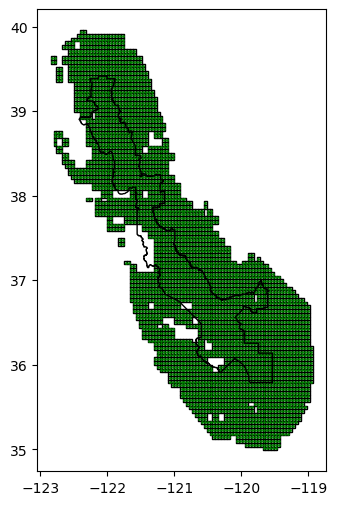

In [5]:
twc_grids_poly = gpd.read_file(twc_grid_poly)
twc_grids_points = gpd.read_file(twc_grid_point)
aoi = gpd.read_file('../shapefiles_grids/cities_California_dissolved.shp')

fig, ax = plt.subplots(figsize=(8, 6))
base = twc_grids_poly.plot(ax=ax, facecolor='white', edgecolor='black')
twc_grids_points.plot(ax=base, facecolor='green', markersize=1)
aoi.plot(ax=ax, facecolor='none', edgecolor='black')  # selected cities of California

## 1.2. Rasterize TWC Weather data daily to `4km`

In [ ]:
twc_weatherdata = '../../datasets/weather_data_shapefiles/twc_weatherdata_cities_california.parquet'
twc_geom_grids = '../../datasets/weather_data_shapefiles/twc_grids_poly_cities_california_4km.shp'
rasterization_dir = '../../datasets/weather_raster_data/cities_California_buffer/twc_data/weather_data_4km'

# Rasterizing grided dataset
process_twc_daily_data(twc_parquet_file=twc_weatherdata, twc_geom_shp=twc_geom_grids, 
                       remove_cols = ['grid_id', 'date', 'index', 'elevation', 'time_zone', 'geometry', 'lat', 'lon'],
                       twc_output_dir=rasterization_dir, ref_raster=cities_california_buffer_4km_refraster)

Processing TWC max_temp dataset...
Processing TWC min_temp dataset...
Processing TWC avg_wind_speed dataset...
Processing TWC avg_Rhumid dataset...
Processing lat, lon dataset...


## 1.3. Masking TWC Weather data for the ROI 
The masked raster shape (height-width)  may not match with the shape of "cities_california" 4km reference raster. This happens due to the masking code which being based on `rasterio` library. The rasterio library has many known issues like this which can be avoided by using `gdal based masking`. Unfortunately, I could not figure out gdal in this AWS instance. 

This is not going to cause any issue as we will not use the reference raster after this point. Also, the TWC and ERA5 datasets' (both 4km, ERA5 resampled to 4km) height-width matches. That will ensure that a daily data for a variable will have the same number of pixels in both TWC and ERA5 and there will be no mismatch in pixel number while compiling datasets into dataframe.

In [3]:
# Masking data for cities_California ROI
rasterized_dir = '../../datasets/weather_raster_data/cities_California_buffer/twc_data/weather_data_4km'
main_masked_dir = '../../datasets/weather_raster_data/cities_California/twc_data/weather_data_4km'
mask_shape = '../shapefiles_grids/cities_California_dissolved.shp'

mask_datasets_with_shapefile(input_raster_dir=rasterized_dir, main_output_dir=main_masked_dir, mask_shape=mask_shape)

Masking data for lon...
Masking data for avg_Rhumid...
Masking data for min_temp...
Masking data for avg_wind_speed...
Masking data for lat...
Masking data for max_temp...


<Axes: >

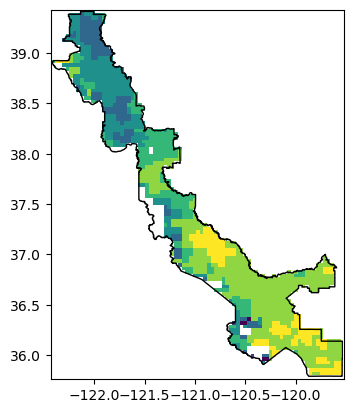

In [3]:
# sample plotting
aoi = gpd.read_file('../shapefiles_grids/cities_California_dissolved.shp')
sample_img = '../../datasets/weather_raster_data/cities_California/twc_data/weather_data_4km/max_temp/max_temp_20210101.tif'
img_arr = rio.open(sample_img)

fig, ax = plt.subplots()
base = aoi.plot(ax=ax, facecolor='none', edgecolor='black') 
show(img_arr, ax=base)

## 1.4. Compiling TWC data in a Dataframe

In [3]:
twc_daily_ddf = compile_twc_daily_data_to_dataframe(savename='twc_historic_weatherdata.parquet', 
                                                    twc_data_folder = '../../datasets/weather_raster_data/cities_California/twc_data/weather_data_4km',
                                                    output_folder = '../../datasets/processed_parquet_data/cities_California/twc_parquet')

compiling data for avg_wind_speed...
compiling data for ...
compiling data for avg_Rhumid...
compiling data for max_temp...
compiling data for min_temp...
time taken 1.449 mins


In [4]:
twc_daily_ddf.head()

,index,avg_wind_speed,date,year,month,day,lon,lat,avg_Rhumid,max_temp,min_temp
0,8,6.80,20150630,2015,6,30,-122.13,39.41,34.50,43.50,18.30
1,9,6.80,20150630,2015,6,30,-122.09,39.41,35.20,43.30,18.40
2,10,6.60,20150630,2015,6,30,-122.05,39.41,36.50,43.10,18.30
3,11,6.60,20150630,2015,6,30,-122.02,39.41,36.50,43.10,18.30
4,86,7.70,20150630,2015,6,30,-122.23,39.38,30.30,43.80,20.00


---------------

# 2. Processing TWC Precipitation Data (8km)

## 2.1. Converting TWC point grids to polygons for California

In [3]:
twc_grid_point ='../../datasets/weather_data_shapefiles/twc_precip_grids_cities_California.shp'
twc_grid_poly = '../../datasets/weather_data_shapefiles/twc_precip_grids_poly_cities_california_8km.shp'

convert_point_geom_to_poly_geom_from_centroid(point_shapefile=twc_grid_point, output_shapefile=twc_grid_poly)

'../../datasets/weather_data_shapefiles/twc_precip_grids_poly_cities_california_8km.shp'

<Axes: >

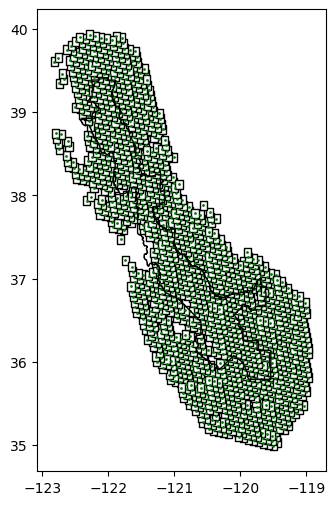

In [4]:
twc_grids_poly = gpd.read_file(twc_grid_poly)
twc_grids_points = gpd.read_file(twc_grid_point)
aoi = gpd.read_file('../shapefiles_grids/cities_California_dissolved.shp')

fig, ax = plt.subplots(figsize=(8, 6))
base = twc_grids_poly.plot(ax=ax, facecolor='white', edgecolor='black')
twc_grids_points.plot(ax=base, facecolor='green', markersize=1)
aoi.plot(ax=ax, facecolor='none', edgecolor='black')  # selected cities of California

__Note:__ The TWC precip grids (8km) creates overlapping polygons (scale-like) when converted from grid points to polygons. This is because the TWC Hi-Res Precipitation grids are not alligned in perpendicular both horizontally and vertically, rather they have a diagonal allignment. See the `Discussion.ipynb` for more discussion.

## 2.2. Process TWC Precipitation data daily to `8km`

In [5]:
twc_precip_data = '../../datasets/weather_data_shapefiles/twc_precipitation_cities_california.parquet'
twc_geom_grids = '../../datasets/weather_data_shapefiles/twc_precip_grids_poly_cities_california_8km.shp'
rasterization_dir = '../../datasets/weather_raster_data/cities_California_buffer/twc_data/precip_data_8km'

# Rasterizing grided dataset
process_twc_daily_data(twc_parquet_file=twc_precip_data, twc_geom_shp=twc_geom_grids, 
                       remove_cols = ['grid_id', 'date', 'index', 'elevation', 'time_zone', 'geometry', 'lat', 'lon'],
                       twc_output_dir=rasterization_dir, ref_raster=cities_california_buffer_8km_refraster)

Processing TWC total_precip dataset...
Processing lat, lon dataset...


## 2.3. Masking TWC Precipitation data for the ROI
The masked raster shape (height-width)  may not match with the shape of "cities_california" 8km reference raster. This happens due to the masking code which being based on `rasterio` library. The rasterio library has many known issues like this which can be avoided by using `gdal based masking`. Unfortunately, I could not figure out gdal in this AWS instance. 

This is not going to cause any issue as we will not use the reference raster after this point. Also, the TWC and ERA5 datasets' (both 8km, ERA5 resampled to 8km) height-width matches. That will ensure that a daily data for a variable will have the same number of pixels in both TWC and ERA5 and there will be no mismatch in pixel number while compiling datasets into dataframe.

In [26]:
# Masking data for cities_California ROI
rasterized_dir = '../..//datasets/weather_raster_data/cities_California_buffer/twc_data/precip_data_8km'
main_masked_dir = '../../datasets/weather_raster_data/cities_California/twc_data/precip_data_8km'
mask_shape = '../shapefiles_grids/cities_California_dissolved.shp'

mask_datasets_with_shapefile(input_raster_dir=rasterized_dir, main_output_dir=main_masked_dir, mask_shape=mask_shape)

Masking data for total_precip...
Masking data for lon...
Masking data for lat...


<Axes: >

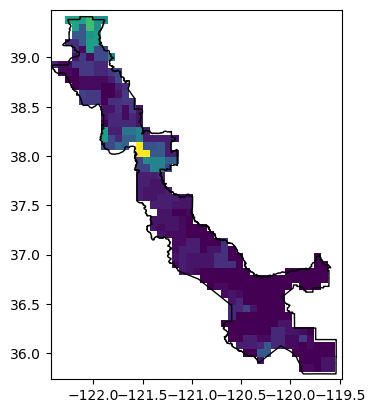

In [30]:
# sample plotting
aoi = gpd.read_file('../shapefiles_grids/cities_California_dissolved.shp')
sample_img = '../../datasets/weather_raster_data/cities_California/twc_data/precip_data_8km/total_precip/total_precip_20210101.tif'
img_arr = rio.open(sample_img)

fig, ax = plt.subplots()
base = aoi.plot(ax=ax, facecolor='none', edgecolor='black') 
show(img_arr, ax=base)

## 2.4. Compiling TWC data in a Dataframe

In [5]:
twc_precip_daily_ddf = compile_twc_daily_data_to_dataframe(savename='twc_historic_precipitation_data.parquet', 
                                                    twc_data_folder = '../..//datasets/weather_raster_data/cities_California/twc_data/precip_data_8km',
                                                    output_folder = '../../datasets/processed_parquet_data/cities_California/twc_parquet')

compiling data for ...
compiling data for total_precip...
time taken 0.237 mins


In [6]:
twc_precip_daily_ddf.head()

,index,lon,lat,total_precip,date,year,month,day
0,43,-122.25,39.37,0.60,20151201,2015,12,1
1,44,-122.18,39.37,0.60,20151201,2015,12,1
2,45,-122.11,39.37,0.60,20151201,2015,12,1
3,46,-122.04,39.37,1.50,20151201,2015,12,1
4,47,-121.96,39.37,0.70,20151201,2015,12,1


----------------------------------------

----------------------------

# 3. Processing ERA5 Weather data daily to `4km`

## 3.1. Rasterizing and Resampling Data

### Here, I am rasterizing ERA5 data to `28km` and resampling to `4km` raster based on `bilinear` resampling

In [ ]:
era5_weatherdata = '../../datasets/weather_data_shapefiles/era5_weatherdata_cities_california.parquet'
era5_geom_grids = '../../datasets/weather_data_shapefiles/era5_grids_cities_california.shp'

process_era5_daily_data(era5_parquet_file=era5_weatherdata, era5_geom_shp=era5_geom_grids, resampling_alg=Resampling.bilinear, 
                        remove_cols = ['grid_id', 'date', 'index', 'lat', 'lon', 'time_zone', 'geometry'],
                        era5_output_dir='../../datasets/weather_raster_data/cities_California_buffer/era5_data',
                        resampled_output_dir= '../../datasets/weather_raster_data/cities_California_buffer/era5_data/resampled_4km_rasters_bilinear',
                        ref_raster_rasterize=cities_california_buffer_28km_refraster, 
                        ref_raster_resample=cities_california_buffer_4km_refraster)

Processing ERA5 total_precip dataset...
Processing ERA5 max_temp dataset...
Processing ERA5 min_temp dataset...
Processing ERA5 max_dew_temp dataset...
Processing ERA5 min_dew_temp dataset...
Processing ERA5 avg_dew_temp dataset...
Processing ERA5 max_wind_speed dataset...
Processing ERA5 min_wind_speed dataset...
Processing ERA5 avg_wind_speed dataset...
Processing ERA5 avg_wind_dir dataset...
Processing ERA5 max_Rhumid dataset...
Processing ERA5 min_Rhumid dataset...
Processing ERA5 avg_Rhumid dataset...
Processing ERA5 max_atmPress dataset...
Processing ERA5 min_atmPress dataset...
Processing ERA5 avg_atmPress dataset...


## 3.2. Masking ERA5 Weather data for the ROI

The masked raster shape (height-width)  may not match with the shape of "cities_california" 4km reference raster. This happens due to the masking code which being based on `rasterio` library. The rasterio library has many known issues like this which can be avoided by using `gdal based masking`. Unfortunately, I could not figure out gdal in this AWS instance. 

This is not going to cause any issue as we will not use the reference raster after this point. Also, the TWC and ERA5 datasets' (both 4km, ERA5 resampled to 4km) height-width matches. That will ensure that a daily data for a variable will have the same number of pixels in both TWC and ERA5 and there will be no mismatch in pixel number while compiling datasets into dataframe.

In [8]:
# Masking data for cities_California regions
rasterized_dir = '../../datasets/weather_raster_data/cities_California_buffer/era5_data/resampled_4km_rasters_bilinear'
main_masked_dir = '../../datasets/weather_raster_data/cities_California/era5_data/resampled_4km_rasters_bilinear'
mask_shape = '../shapefiles_grids/cities_California_dissolved.shp'

mask_datasets_with_shapefile(input_raster_dir=rasterized_dir, main_output_dir=main_masked_dir, mask_shape=mask_shape)

Masking data for avg_wind_speed...
Masking data for eto...
Masking data for min_atmPress...
Masking data for avg_Cloud...
Masking data for max_wind_speed...
Masking data for MaxDown_SR...
Masking data for TotNet_SR...
Masking data for avg_atmPress...
Masking data for max_dew_temp...
Masking data for avg_SM_L1...
Masking data for avg_dew_temp...
Masking data for MaxNet_SR...
Masking data for min_Rhumid...
Masking data for min_dew_temp...
Masking data for max_atmPress...
Masking data for avg_wind_dir...
Masking data for avg_Rhumid...
Masking data for etr...
Masking data for avg_ST_L1...
Masking data for avg_snow_depth...
Masking data for max_temp...
Masking data for max_Rhumid...
Masking data for TotDown_SR...
Masking data for min_wind_speed...
Masking data for total_precip...
Masking data for min_temp...


<Axes: >

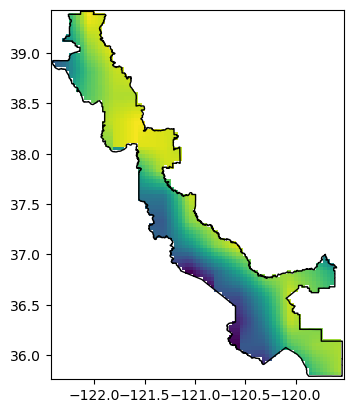

In [5]:
# sample plotting
aoi = gpd.read_file('../shapefiles_grids/cities_California_dissolved.shp')
sample_img = '../../datasets/weather_raster_data/cities_California/era5_data/resampled_4km_rasters_bilinear/avg_atmPress/avg_atmPress_20210101.tif'
img_arr = rio.open(sample_img)

fig, ax = plt.subplots()
base = aoi.plot(ax=ax, facecolor='none', edgecolor='black') 
show(img_arr, ax=base)

## 3.3.  Copying latitude longitude data from TWC to ERA5

In [6]:
lat_data = glob(os.path.join('../../datasets/weather_raster_data/cities_California/twc_data/weather_data_4km/lat', '*.tif'))[0]
lon_data = glob(os.path.join('../../datasets/weather_raster_data/cities_California/twc_data/weather_data_4km/lon', '*.tif'))[0]

lat_copy_dir = '../../datasets/weather_raster_data/cities_California/era5_data/resampled_4km_rasters_bilinear/lat'
lon_copy_dir = '../../datasets/weather_raster_data/cities_California/era5_data/resampled_4km_rasters_bilinear/lon'

# copying latitude data
copy_file(input_dir_file=lat_data, copy_dir=lat_copy_dir, search_by='*.tif', rename='lat')

# copying longitude data
copy_file(input_dir_file=lon_data, copy_dir=lon_copy_dir, search_by='*.tif', rename='lon')

'../../datasets/weather_raster_data/cities_California/era5_data/resampled_4km_rasters_bilinear/lon/lon.tif'

## 3.4. Copying Elevation + Slope + Aspect Data

In [7]:
elevation_data = '../../datasets/elevation_raster_data/cities_california/elevation/elevation_4km.tif'
slope_data = '../../datasets/elevation_raster_data/cities_california/slope/slope_4km.tif'
aspect_data = '../../datasets/elevation_raster_data/cities_california/aspect/aspect_4km.tif'

elevation_copy_dir = '../../datasets/weather_raster_data/cities_California/era5_data/resampled_4km_rasters_bilinear/elevation'
slope_copy_dir = '../../datasets/weather_raster_data/cities_California/era5_data/resampled_4km_rasters_bilinear/slope'
aspect_copy_dir = '../../datasets/weather_raster_data/cities_California/era5_data/resampled_4km_rasters_bilinear/aspect'

# copying elevation + slope + aspect data
copy_file(input_dir_file=elevation_data, copy_dir=elevation_copy_dir, search_by='*.tif', rename='elevation')
copy_file(input_dir_file=slope_data, copy_dir=slope_copy_dir, search_by='*.tif', rename='slope')
copy_file(input_dir_file=aspect_data, copy_dir=aspect_copy_dir, search_by='*.tif', rename='aspect')

'../../datasets/weather_raster_data/cities_California/era5_data/resampled_4km_rasters_bilinear/aspect/aspect.tif'

## 3.5. Compiling ERA5 data `(4km)` from Rasters to Multiple Dataframes

#### Note
If the AOI is large, it is recommended to process ERA5 in chunks. In this approach, 'n' number of datasets will be processed together and saved as a parquet. Multiple parquet files will be generated and they need to be joined together to create a single ERA5 dataframe with all the ERA5 variables. 


Currently, this processing in chunks approach has been applied only in ERA5 datasets as it consist of many variables. TWC compilation doesn't have this feature (not needed as TWC has fewer variables). But with large AOI, this 'processing in chunks' feature might be needed for TWC as well.

In [8]:
compile_era5_daily_data_to_multiple_dataframe(save_keyword='4km',
                                              era5_data_folder = '../../datasets/weather_raster_data/cities_California/era5_data/resampled_4km_rasters_bilinear',
                                              output_folder = '../../datasets/processed_parquet_data/cities_California/era5_parquet/multiple_dataframes_4km',
                                              dataset_in_each_chunk=5)

processing for ['avg_wind_speed', 'eto', 'min_atmPress', 'slope', 'avg_Cloud', 'lat', 'lon']..
compiling data for avg_wind_speed...
compiling data for eto...
compiling data for min_atmPress...
compiling data for slope...
compiling data for avg_Cloud...
compiling data for lat...
compiling data for lon...
time taken 3.811 mins
processing for ['max_wind_speed', 'aspect', 'MaxDown_SR', 'TotNet_SR', 'lat', 'lon']..
compiling data for max_wind_speed...
compiling data for aspect...
compiling data for MaxDown_SR...
compiling data for TotNet_SR...
compiling data for lat...
compiling data for lon...
time taken 3.067 mins
processing for ['avg_atmPress', 'max_dew_temp', 'avg_SM_L1', 'avg_dew_temp', 'lat', 'lon']..
compiling data for avg_atmPress...
compiling data for max_dew_temp...
compiling data for avg_SM_L1...
compiling data for avg_dew_temp...
compiling data for lat...
compiling data for lon...
time taken 3.516 mins
processing for ['MaxNet_SR', 'elevation', 'min_Rhumid', 'min_dew_temp', 'max_

## 3.6. Compiling ERA5 `(4km)` data from Multiple Dataframes to a Single Dataframe

In [9]:
parquet_files_folder = '../../datasets/processed_parquet_data/cities_California/era5_parquet/multiple_dataframes_4km'
output_folder='../../datasets/processed_parquet_data/cities_California/era5_parquet'

compiled_df = compile_era5_multiDF_to_singleDF(save_keyword='4km',
                                               parquet_folder=parquet_files_folder, output_folder=output_folder)

compiled_df.head(10)

,MaxNet_SR,date,elevation,min_Rhumid,min_dew_temp,max_atmPress,lat,lon,max_wind_speed,aspect,...,avg_Cloud,avg_atmPress,max_dew_temp,avg_SM_L1,avg_dew_temp,avg_wind_dir,avg_Rhumid,etr,avg_ST_L1,avg_snow_depth
0,0.17,20020101,22.05,87.83,10.32,1013.52,39.41,-122.13,13.35,152.86,...,1.00,1011.42,13.02,0.42,12.24,142.07,93.39,0.70,12.99,0.00
1,0.17,20020101,20.40,87.47,10.47,1017.23,39.41,-122.09,13.60,176.14,...,1.00,1015.13,13.15,0.42,12.36,139.79,93.23,0.72,13.13,0.00
2,0.16,20020101,20.52,87.03,10.54,1019.88,39.41,-122.05,13.76,179.87,...,1.00,1017.78,13.21,0.42,12.43,137.43,92.93,0.75,13.23,0.00
3,0.16,20020101,22.94,86.35,10.34,1018.71,39.41,-122.02,13.58,139.17,...,1.00,1016.62,13.09,0.42,12.29,134.75,92.16,0.77,13.20,0.00
4,0.18,20020101,30.53,89.15,9.88,1001.41,39.38,-122.23,12.38,145.41,...,1.00,999.31,12.66,0.42,11.87,150.15,94.12,0.64,12.55,0.00
5,0.18,20020101,26.75,88.82,10.04,1005.17,39.38,-122.20,12.65,159.06,...,1.00,1003.07,12.78,0.42,12.00,147.92,93.99,0.66,12.69,0.00
6,0.18,20020101,22.68,88.49,10.19,1008.93,39.38,-122.16,12.91,153.96,...,1.00,1006.83,12.89,0.42,12.12,145.68,93.85,0.68,12.83,0.00
7,0.17,20020101,20.07,88.17,10.35,1012.69,39.38,-122.13,13.18,168.68,...,1.00,1010.59,13.01,0.42,12.25,143.45,93.71,0.69,12.98,0.00
8,0.17,20020101,18.73,87.84,10.50,1016.46,39.38,-122.09,13.45,177.26,...,1.00,1014.36,13.13,0.42,12.38,141.21,93.57,0.71,13.12,0.00
9,0.16,20020101,19.88,87.45,10.59,1019.18,39.38,-122.05,13.61,182.78,...,1.00,1017.08,13.20,0.42,12.45,138.87,93.30,0.73,13.22,0.00


In [10]:
compiled_df.columns

Index(['MaxNet_SR', 'date', 'elevation', 'min_Rhumid', 'min_dew_temp',
       'max_atmPress', 'lat', 'lon', 'max_wind_speed', 'aspect', 'MaxDown_SR',
       'TotNet_SR', 'min_temp', 'max_temp', 'max_Rhumid', 'TotDown_SR',
       'min_wind_speed', 'total_precip', 'avg_wind_speed', 'eto',
       'min_atmPress', 'slope', 'avg_Cloud', 'avg_atmPress', 'max_dew_temp',
       'avg_SM_L1', 'avg_dew_temp', 'avg_wind_dir', 'avg_Rhumid', 'etr',
       'avg_ST_L1', 'avg_snow_depth'],
      dtype='object')

-----------------------

-----------------------------------

# 4. Processing ERA5 Weather data daily to `8km`

## 4.1. Rasterizing and Resampling Data

### Here, I am rasterizing ERA5 data to `28km` and resampling to `8km` raster based on `bilinear` resampling

In [11]:
era5_weatherdata = '../../datasets/weather_data_shapefiles/era5_weatherdata_cities_california.parquet'
era5_geom_grids = '../../datasets/weather_data_shapefiles/era5_grids_cities_california.shp'

process_era5_daily_data(era5_parquet_file=era5_weatherdata, era5_geom_shp=era5_geom_grids, resampling_alg=Resampling.bilinear, 
                        remove_cols = ['grid_id', 'date', 'index', 'lat', 'lon', 'time_zone', 'geometry'],
                        era5_output_dir='../../datasets/weather_raster_data/cities_California/era5_data',
                        resampled_output_dir= '../../datasets/weather_raster_data/cities_California_buffer/era5_data/resampled_8km_rasters_bilinear',
                        ref_raster_rasterize=cities_california_buffer_28km_refraster, 
                        ref_raster_resample=cities_california_buffer_8km_refraster)

Processing ERA5 total_precip dataset...
Processing ERA5 max_temp dataset...
Processing ERA5 min_temp dataset...
Processing ERA5 max_dew_temp dataset...
Processing ERA5 min_dew_temp dataset...
Processing ERA5 avg_dew_temp dataset...
Processing ERA5 max_wind_speed dataset...
Processing ERA5 min_wind_speed dataset...
Processing ERA5 avg_wind_speed dataset...
Processing ERA5 avg_wind_dir dataset...
Processing ERA5 max_Rhumid dataset...
Processing ERA5 min_Rhumid dataset...
Processing ERA5 avg_Rhumid dataset...
Processing ERA5 max_atmPress dataset...
Processing ERA5 min_atmPress dataset...
Processing ERA5 avg_atmPress dataset...
Processing ERA5 avg_snow_depth dataset...
Processing ERA5 avg_Cloud dataset...
Processing ERA5 TotDown_SR dataset...
Processing ERA5 MaxDown_SR dataset...
Processing ERA5 TotNet_SR dataset...
Processing ERA5 MaxNet_SR dataset...
Processing ERA5 avg_ST_L1 dataset...
Processing ERA5 avg_SM_L1 dataset...
Processing ERA5 eto dataset...
Processing ERA5 etr dataset...


## 4.2. Masking ERA5 Weather data for the ROI

The masked raster shape (height-width)  may not match with the shape of "cities_california" 8km reference raster. This happens due to the masking code which being based on `rasterio` library. The rasterio library has many known issues like this which can be avoided by using `gdal based masking`. Unfortunately, I could not figure out gdal in this AWS instance. 

This is not going to cause any issue as we will not use the reference raster after this point. Also, the TWC and ERA5 datasets' (both 8km, ERA5 resampled to 8km) height-width matches. That will ensure that a daily data for a variable will have the same number of pixels in both TWC and ERA5 and there will be no mismatch in pixel number while compiling datasets into dataframe.

In [5]:
# Masking data for cities_California regions
rasterized_dir = '../../datasets/weather_raster_data/cities_California_buffer/era5_data/resampled_8km_rasters_bilinear'
main_masked_dir = '../../datasets/weather_raster_data/cities_California/era5_data/resampled_8km_rasters_bilinear'
mask_shape = '../shapefiles_grids/cities_California_dissolved.shp'

mask_datasets_with_shapefile(input_raster_dir=rasterized_dir, main_output_dir=main_masked_dir, mask_shape=mask_shape,
                             exclude_datasets=None)

Masking data for max_Rhumid...
Masking data for TotDown_SR...
Masking data for min_wind_speed...
Masking data for total_precip...
Masking data for min_temp...


## 4.3.  Copying latitude longitude data from TWC to ERA5

In [6]:
lat_data = glob(os.path.join('../../datasets/weather_raster_data/cities_California/twc_data/precip_data_8km/lat', '*.tif'))[0]
lon_data = glob(os.path.join('../../datasets/weather_raster_data/cities_California/twc_data/precip_data_8km/lon', '*.tif'))[0]

lat_copy_dir = '../../datasets/weather_raster_data/cities_California/era5_data/resampled_8km_rasters_bilinear/lat'
lon_copy_dir = '../../datasets/weather_raster_data/cities_California/era5_data/resampled_8km_rasters_bilinear/lon'

# copying latitude data
copy_file(input_dir_file=lat_data, copy_dir=lat_copy_dir, search_by='*.tif', rename='lat')

# copying longitude data
copy_file(input_dir_file=lon_data, copy_dir=lon_copy_dir, search_by='*.tif', rename='lon')

'../../datasets/weather_raster_data/cities_California/era5_data/resampled_8km_rasters_bilinear/lon/lon.tif'

## 4.4. Copying Elevation + Slope + Aspect Data

In [7]:
elevation_data = '../../datasets/elevation_raster_data/cities_california/elevation/elevation_8km.tif'
slope_data = '../../datasets/elevation_raster_data/cities_california/slope/slope_8km.tif'
aspect_data = '../../datasets/elevation_raster_data/cities_california/aspect/aspect_8km.tif'

elevation_copy_dir = '../../datasets/weather_raster_data/cities_California/era5_data/resampled_8km_rasters_bilinear/elevation'
slope_copy_dir = '../../datasets/weather_raster_data/cities_California/era5_data/resampled_8km_rasters_bilinear/slope'
aspect_copy_dir = '../../datasets/weather_raster_data/cities_California/era5_data/resampled_8km_rasters_bilinear/aspect'

# copying elevation + slope + aspect data
copy_file(input_dir_file=elevation_data, copy_dir=elevation_copy_dir, search_by='*.tif', rename='elevation')
copy_file(input_dir_file=slope_data, copy_dir=slope_copy_dir, search_by='*.tif', rename='slope')
copy_file(input_dir_file=aspect_data, copy_dir=aspect_copy_dir, search_by='*.tif', rename='aspect')

'../../datasets/weather_raster_data/cities_California/era5_data/resampled_8km_rasters_bilinear/aspect/aspect.tif'

## 4.5. Compiling ERA5 data `(8km)` from Rasters to Multiple Dataframes

#### Note
If the AOI is large, it is recommended to process ERA5 in chunks. In this approach, 'n' number of datasets will be processed together and saved as a parquet. Multiple parquet files will be generated and they need to be joined together to create a single ERA5 dataframe with all the ERA5 variables. 

Currently, this processing in chunks approach has been applied only in ERA5 datasets as it consist of many variables. TWC compilation doesn't have this feature (not needed as TWC has fewer variables). But with large AOI, this 'processing in chunks' feature might be needed for TWC as well.

In [14]:
compile_era5_daily_data_to_multiple_dataframe(save_keyword='8km',
                                              era5_data_folder = '../../datasets/weather_raster_data/cities_California/era5_data/resampled_8km_rasters_bilinear',
                                              output_folder = '../../datasets/processed_parquet_data/cities_California/era5_parquet/multiple_dataframes_8km',
                                              dataset_in_each_chunk=5)

processing for ['avg_wind_speed', 'eto', 'min_atmPress', 'slope', 'avg_Cloud', 'lat', 'lon']..
compiling data for avg_wind_speed...
compiling data for eto...
compiling data for min_atmPress...
compiling data for slope...
compiling data for avg_Cloud...
compiling data for lat...
compiling data for lon...
time taken 1.664 mins
processing for ['max_wind_speed', 'aspect', 'MaxDown_SR', 'TotNet_SR', 'lat', 'lon']..
compiling data for max_wind_speed...
compiling data for aspect...
compiling data for MaxDown_SR...
compiling data for TotNet_SR...
compiling data for lat...
compiling data for lon...
time taken 1.303 mins
processing for ['avg_atmPress', 'max_dew_temp', 'avg_SM_L1', 'avg_dew_temp', 'lat', 'lon']..
compiling data for avg_atmPress...
compiling data for max_dew_temp...
compiling data for avg_SM_L1...
compiling data for avg_dew_temp...
compiling data for lat...
compiling data for lon...
time taken 1.614 mins
processing for ['MaxNet_SR', 'elevation', 'min_Rhumid', 'min_dew_temp', 'max_

## 4.5. Compiling ERA5 `(8km)` data from Multiple Dataframes to a Single Dataframe

In [15]:
parquet_files_folder = '../../datasets/processed_parquet_data/cities_California/era5_parquet/multiple_dataframes_8km'
output_folder='../../datasets/processed_parquet_data/cities_California/era5_parquet'

compiled_df = compile_era5_multiDF_to_singleDF(save_keyword='8km',
                                               parquet_folder=parquet_files_folder, output_folder=output_folder)

compiled_df

,avg_wind_dir,date,avg_Rhumid,etr,avg_ST_L1,avg_snow_depth,lat,lon,avg_atmPress,max_dew_temp,...,total_precip,avg_wind_speed,eto,min_atmPress,slope,avg_Cloud,max_wind_speed,aspect,MaxDown_SR,TotNet_SR
0,151.87,20020101,94.26,0.63,12.45,0.00,39.37,-122.25,996.61,12.58,...,16.58,6.84,0.52,994.93,38.35,1.00,12.16,69.33,0.21,0.98
1,147.45,20020101,94.00,0.66,12.73,0.00,39.37,-122.18,1004.08,12.81,...,15.25,7.05,0.55,1002.42,88.62,1.00,12.70,159.84,0.20,0.97
2,143.04,20020101,93.73,0.70,13.01,0.00,39.37,-122.11,1011.55,13.05,...,13.91,7.26,0.58,1009.92,83.41,1.00,13.23,160.73,0.19,0.96
3,138.39,20020101,93.17,0.73,13.21,0.00,39.37,-122.04,1016.68,13.17,...,12.78,7.40,0.61,1015.08,88.56,1.00,13.53,178.00,0.18,0.96
4,133.02,20020101,91.72,0.77,13.16,0.00,39.37,-121.96,1014.78,12.95,...,12.22,7.34,0.64,1013.27,85.16,1.00,13.14,166.67,0.18,0.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3045505,283.19,20120909,36.19,7.15,25.64,0.00,37.65,-121.53,981.50,9.26,...,0.00,7.47,5.23,979.52,63.46,0.00,11.55,118.68,3.11,19.57
3045506,285.69,20120909,35.92,7.16,25.72,0.00,37.65,-121.46,982.68,9.26,...,0.00,7.42,5.24,980.69,89.99,0.00,11.45,157.66,3.10,19.56
3045507,288.19,20120909,35.65,7.18,25.80,0.00,37.65,-121.39,983.86,9.26,...,0.00,7.37,5.26,981.85,89.97,0.00,11.35,150.21,3.10,19.55
3045508,290.69,20120909,35.38,7.19,25.88,0.00,37.65,-121.32,985.03,9.26,...,0.00,7.32,5.27,983.01,89.91,0.00,11.24,152.92,3.10,19.55


----------------------

----------------------

# 5. Combining TWC and ERA5 Dataframes `(4km)`

In [5]:
era5_data= '../../datasets/processed_parquet_data/cities_California/era5_parquet/4km_era5_daily_data.parquet'

era5_df_4km = pd.read_parquet(era5_data)
print(era5_df_4km.columns)
era5_df_4km.head(10)

Index(['MaxNet_SR', 'date', 'elevation', 'min_Rhumid', 'min_dew_temp',
       'max_atmPress', 'lat', 'lon', 'max_wind_speed', 'aspect', 'MaxDown_SR',
       'TotNet_SR', 'min_temp', 'max_temp', 'max_Rhumid', 'TotDown_SR',
       'min_wind_speed', 'total_precip', 'avg_wind_speed', 'eto',
       'min_atmPress', 'slope', 'avg_Cloud', 'avg_atmPress', 'max_dew_temp',
       'avg_SM_L1', 'avg_dew_temp', 'avg_wind_dir', 'avg_Rhumid', 'etr',
       'avg_ST_L1', 'avg_snow_depth'],
      dtype='object')


,MaxNet_SR,date,elevation,min_Rhumid,min_dew_temp,max_atmPress,lat,lon,max_wind_speed,aspect,...,avg_Cloud,avg_atmPress,max_dew_temp,avg_SM_L1,avg_dew_temp,avg_wind_dir,avg_Rhumid,etr,avg_ST_L1,avg_snow_depth
0,0.17,20020101,22.05,87.83,10.32,1013.52,39.41,-122.13,13.35,152.86,...,1.00,1011.42,13.02,0.42,12.24,142.07,93.39,0.70,12.99,0.00
1,0.17,20020101,20.40,87.47,10.47,1017.23,39.41,-122.09,13.60,176.14,...,1.00,1015.13,13.15,0.42,12.36,139.79,93.23,0.72,13.13,0.00
2,0.16,20020101,20.52,87.03,10.54,1019.88,39.41,-122.05,13.76,179.87,...,1.00,1017.78,13.21,0.42,12.43,137.43,92.93,0.75,13.23,0.00
3,0.16,20020101,22.94,86.35,10.34,1018.71,39.41,-122.02,13.58,139.17,...,1.00,1016.62,13.09,0.42,12.29,134.75,92.16,0.77,13.20,0.00
4,0.18,20020101,30.53,89.15,9.88,1001.41,39.38,-122.23,12.38,145.41,...,1.00,999.31,12.66,0.42,11.87,150.15,94.12,0.64,12.55,0.00
5,0.18,20020101,26.75,88.82,10.04,1005.17,39.38,-122.20,12.65,159.06,...,1.00,1003.07,12.78,0.42,12.00,147.92,93.99,0.66,12.69,0.00
6,0.18,20020101,22.68,88.49,10.19,1008.93,39.38,-122.16,12.91,153.96,...,1.00,1006.83,12.89,0.42,12.12,145.68,93.85,0.68,12.83,0.00
7,0.17,20020101,20.07,88.17,10.35,1012.69,39.38,-122.13,13.18,168.68,...,1.00,1010.59,13.01,0.42,12.25,143.45,93.71,0.69,12.98,0.00
8,0.17,20020101,18.73,87.84,10.50,1016.46,39.38,-122.09,13.45,177.26,...,1.00,1014.36,13.13,0.42,12.38,141.21,93.57,0.71,13.12,0.00
9,0.16,20020101,19.88,87.45,10.59,1019.18,39.38,-122.05,13.61,182.78,...,1.00,1017.08,13.20,0.42,12.45,138.87,93.30,0.73,13.22,0.00


In [6]:
twc_weather_data= '../../datasets/processed_parquet_data/cities_California/twc_parquet/twc_historic_weatherdata.parquet'

twc_weather_df = pd.read_parquet(twc_weather_data)
print(twc_weather_df.columns)
twc_weather_df.head(10)

Index(['index', 'avg_wind_speed', 'date', 'year', 'month', 'day', 'lon', 'lat',
       'avg_Rhumid', 'max_temp', 'min_temp'],
      dtype='object')


,index,avg_wind_speed,date,year,month,day,lon,lat,avg_Rhumid,max_temp,min_temp
__null_dask_index__,,,,,,,,,,,
0,8,6.80,20150630,2015,6,30,-122.13,39.41,34.50,43.50,18.30
1,9,6.80,20150630,2015,6,30,-122.09,39.41,35.20,43.30,18.40
2,10,6.60,20150630,2015,6,30,-122.05,39.41,36.50,43.10,18.30
3,11,6.60,20150630,2015,6,30,-122.02,39.41,36.50,43.10,18.30
4,86,7.70,20150630,2015,6,30,-122.23,39.38,30.30,43.80,20.00
5,87,7.00,20150630,2015,6,30,-122.20,39.38,33.30,43.60,18.50
6,88,7.00,20150630,2015,6,30,-122.16,39.38,33.30,43.60,18.50
7,89,6.80,20150630,2015,6,30,-122.13,39.38,34.50,43.50,18.30
8,90,7.00,20150630,2015,6,30,-122.09,39.38,35.80,43.10,18.10


In [7]:
era5_data= '../../datasets/processed_parquet_data/cities_California/era5_parquet/4km_era5_daily_data.parquet'
twc_weather_data= '../../datasets/processed_parquet_data/cities_California/twc_parquet/twc_historic_weatherdata.parquet'
combined_dataset = '../../datasets/processed_parquet_data/cities_California/twc_era5_weather_data_cities_California.parquet'

combined_df = combine_twc_era5_datasets(twc_dataset=twc_weather_data, era5_dataset=era5_data, output_file=combined_dataset, 
                                        merge_on=['date', 'lat', 'lon'], how='inner')

In [8]:
print(combined_df.columns)
combined_df.head()

Index(['index', 'avg_wind_speed_twc', 'date', 'year', 'month', 'day', 'lon',
       'lat', 'avg_Rhumid_twc', 'max_temp_twc', 'min_temp_twc', 'MaxNet_SR',
       'elevation', 'min_Rhumid', 'min_dew_temp', 'max_atmPress',
       'max_wind_speed', 'aspect', 'MaxDown_SR', 'TotNet_SR', 'min_temp_era5',
       'max_temp_era5', 'max_Rhumid', 'TotDown_SR', 'min_wind_speed',
       'total_precip', 'avg_wind_speed_era5', 'eto', 'min_atmPress', 'slope',
       'avg_Cloud', 'avg_atmPress', 'max_dew_temp', 'avg_SM_L1',
       'avg_dew_temp', 'avg_wind_dir', 'avg_Rhumid_era5', 'etr', 'avg_ST_L1',
       'avg_snow_depth'],
      dtype='object')


,index,avg_wind_speed_twc,date,year,month,day,lon,lat,avg_Rhumid_twc,max_temp_twc,...,avg_Cloud,avg_atmPress,max_dew_temp,avg_SM_L1,avg_dew_temp,avg_wind_dir,avg_Rhumid_era5,etr,avg_ST_L1,avg_snow_depth
0,8,6.80,20150630,2015,6,30,-122.13,39.41,34.50,43.50,...,0.58,1004.14,15.03,0.13,9.91,136.55,26.55,9.59,32.79,0.00
1,9,6.80,20150630,2015,6,30,-122.09,39.41,35.20,43.30,...,0.59,1007.56,14.92,0.13,10.18,136.92,26.78,9.62,32.85,0.00
2,10,6.60,20150630,2015,6,30,-122.05,39.41,36.50,43.10,...,0.60,1010.00,14.89,0.13,10.44,136.93,27.07,9.60,32.87,0.00
3,11,6.60,20150630,2015,6,30,-122.02,39.41,36.50,43.10,...,0.61,1008.91,15.13,0.13,10.65,135.67,27.59,9.44,32.74,0.00
4,86,7.70,20150630,2015,6,30,-122.23,39.38,30.30,43.80,...,0.56,992.96,15.41,0.12,9.03,138.35,26.01,9.45,32.58,0.00


In [9]:
print(f'twc_weather_df len: {len(twc_weather_df)}')
print(f'era5_df_4km len: {len(era5_df_4km)}')
print(f'twc_era5_combined len: {len(combined_df)}')

twc_weather_df len: 4418833
era5_df_4km len: 12658389
twc_era5_combined len: 4400353


--------------------------

# 6. Combining TWC and ERA5 Dataframes `(8km)`

In [16]:
era5_data= '../../datasets/processed_parquet_data/cities_California/era5_parquet/8km_era5_daily_data.parquet'

era5_df_8km = pd.read_parquet(era5_data)
print(era5_df_8km.columns)
era5_df_8km

Index(['avg_wind_dir', 'date', 'avg_Rhumid', 'etr', 'avg_ST_L1',
       'avg_snow_depth', 'lat', 'lon', 'avg_atmPress', 'max_dew_temp',
       'avg_SM_L1', 'avg_dew_temp', 'min_temp', 'MaxNet_SR', 'elevation',
       'min_Rhumid', 'min_dew_temp', 'max_atmPress', 'max_temp', 'max_Rhumid',
       'TotDown_SR', 'min_wind_speed', 'total_precip', 'avg_wind_speed', 'eto',
       'min_atmPress', 'slope', 'avg_Cloud', 'max_wind_speed', 'aspect',
       'MaxDown_SR', 'TotNet_SR'],
      dtype='object')


,avg_wind_dir,date,avg_Rhumid,etr,avg_ST_L1,avg_snow_depth,lat,lon,avg_atmPress,max_dew_temp,...,total_precip,avg_wind_speed,eto,min_atmPress,slope,avg_Cloud,max_wind_speed,aspect,MaxDown_SR,TotNet_SR
0,151.87,20020101,94.26,0.63,12.45,0.00,39.37,-122.25,996.61,12.58,...,16.58,6.84,0.52,994.93,38.35,1.00,12.16,69.33,0.21,0.98
1,147.45,20020101,94.00,0.66,12.73,0.00,39.37,-122.18,1004.08,12.81,...,15.25,7.05,0.55,1002.42,88.62,1.00,12.70,159.84,0.20,0.97
2,143.04,20020101,93.73,0.70,13.01,0.00,39.37,-122.11,1011.55,13.05,...,13.91,7.26,0.58,1009.92,83.41,1.00,13.23,160.73,0.19,0.96
3,138.39,20020101,93.17,0.73,13.21,0.00,39.37,-122.04,1016.68,13.17,...,12.78,7.40,0.61,1015.08,88.56,1.00,13.53,178.00,0.18,0.96
4,133.02,20020101,91.72,0.77,13.16,0.00,39.37,-121.96,1014.78,12.95,...,12.22,7.34,0.64,1013.27,85.16,1.00,13.14,166.67,0.18,0.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3045505,283.19,20120909,36.19,7.15,25.64,0.00,37.65,-121.53,981.50,9.26,...,0.00,7.47,5.23,979.52,63.46,0.00,11.55,118.68,3.11,19.57
3045506,285.69,20120909,35.92,7.16,25.72,0.00,37.65,-121.46,982.68,9.26,...,0.00,7.42,5.24,980.69,89.99,0.00,11.45,157.66,3.10,19.56
3045507,288.19,20120909,35.65,7.18,25.80,0.00,37.65,-121.39,983.86,9.26,...,0.00,7.37,5.26,981.85,89.97,0.00,11.35,150.21,3.10,19.55
3045508,290.69,20120909,35.38,7.19,25.88,0.00,37.65,-121.32,985.03,9.26,...,0.00,7.32,5.27,983.01,89.91,0.00,11.24,152.92,3.10,19.55


In [17]:
twc_precip_data= '../../datasets/processed_parquet_data/cities_California/twc_parquet/twc_historic_precipitation_data.parquet'

twc_precip_df = pd.read_parquet(twc_precip_data)
print(twc_precip_df.columns)
twc_precip_df

Index(['index', 'lon', 'lat', 'total_precip', 'date', 'year', 'month', 'day'], dtype='object')


,index,lon,lat,total_precip,date,year,month,day
__null_dask_index__,,,,,,,,
0,43,-122.25,39.37,0.60,20151201,2015,12,1
1,44,-122.18,39.37,0.60,20151201,2015,12,1
2,45,-122.11,39.37,0.60,20151201,2015,12,1
3,46,-122.04,39.37,1.50,20151201,2015,12,1
4,47,-121.96,39.37,0.70,20151201,2015,12,1
...,...,...,...,...,...,...,...,...
52858,2807446,-121.53,37.65,0.00,20190831,2019,8,31
52859,2807447,-121.46,37.65,0.00,20190831,2019,8,31
52860,2807448,-121.39,37.65,0.00,20190831,2019,8,31


In [18]:
era5_data= '../../datasets/processed_parquet_data/cities_California/era5_parquet/8km_era5_daily_data.parquet'
twc_precip_data= '../../datasets/processed_parquet_data/cities_California/twc_parquet/twc_historic_precipitation_data.parquet'
combined_dataset = '../../datasets/processed_parquet_data/cities_California/twc_era5_precip_data_cities_California.parquet'

combined_df = combine_twc_era5_datasets(twc_dataset=twc_precip_data, era5_dataset=era5_data, 
                                        output_file=combined_dataset, 
                                        merge_on=['date', 'lat', 'lon'], how='inner')

print(combined_df.columns)
combined_df.head()

Index(['index', 'lon', 'lat', 'total_precip_twc', 'date', 'year', 'month',
       'day', 'avg_wind_dir', 'avg_Rhumid', 'etr', 'avg_ST_L1',
       'avg_snow_depth', 'avg_atmPress', 'max_dew_temp', 'avg_SM_L1',
       'avg_dew_temp', 'min_temp', 'MaxNet_SR', 'elevation', 'min_Rhumid',
       'min_dew_temp', 'max_atmPress', 'max_temp', 'max_Rhumid', 'TotDown_SR',
       'min_wind_speed', 'total_precip_era5', 'avg_wind_speed', 'eto',
       'min_atmPress', 'slope', 'avg_Cloud', 'max_wind_speed', 'aspect',
       'MaxDown_SR', 'TotNet_SR'],
      dtype='object')


,index,lon,lat,total_precip_twc,date,year,month,day,avg_wind_dir,avg_Rhumid,...,total_precip_era5,avg_wind_speed,eto,min_atmPress,slope,avg_Cloud,max_wind_speed,aspect,MaxDown_SR,TotNet_SR
0,43,-122.25,39.37,0.60,20151201,2015,12,1,267.58,53.59,...,0.35,5.54,1.29,1001.87,38.35,0.77,8.75,69.33,1.70,8.40
1,44,-122.18,39.37,0.60,20151201,2015,12,1,274.95,51.51,...,0.29,5.87,1.40,1009.39,88.62,0.77,9.11,159.84,1.71,8.47
2,45,-122.11,39.37,0.60,20151201,2015,12,1,282.33,49.42,...,0.23,6.20,1.51,1016.92,83.41,0.76,9.47,160.73,1.72,8.53
3,46,-122.04,39.37,1.50,20151201,2015,12,1,268.31,48.45,...,0.19,6.35,1.57,1022.08,88.56,0.75,9.67,178.00,1.72,8.59
4,47,-121.96,39.37,0.70,20151201,2015,12,1,190.12,50.79,...,0.17,5.94,1.46,1020.14,85.16,0.75,9.39,166.67,1.73,8.59


In [19]:
print(f'twc_precip_df len: {len(twc_precip_df)}')
print(f'era5_df_8km len: {len(era5_df_8km)}')
print(f'twc_era5_combined len: {len(combined_df)}')

twc_precip_df len: 1051751
era5_df_8km len: 3045510
twc_era5_combined len: 1047119
